In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
import ipywidgets

In [13]:
def haldane_hamiltonian(k, params):
    t = params["t"]
    t2 = params["t2"]
    M = params["M"]
    phi = params["phi"]

    # Define the nearest and next-nearest neighbor vectors for the honeycomb lattice
    delta1 = np.array([[1, 0], [-1/2, np.sqrt(3)/2], [-1/2, -np.sqrt(3)/2]])
    delta2 = np.array([[1/2, np.sqrt(3)/2], [1/2, -np.sqrt(3)/2], [-1, 0]])
    H = np.zeros((2, 2), dtype=complex)

    # Nearest-neighbor hopping term
    for d in delta1:
        H[0, 1] += -t * np.exp(1j * np.dot(k, d))
        H[1, 0] += -t * np.exp(-1j * np.dot(k, d))

    # On-site potential (staggered potential)
    H[0, 0] += M
    H[1, 1] += -M

    # Next-nearest-neighbor hopping term with complex phase
    for d in delta2:
        H[0, 0] += 2 * t2 * np.sin(np.dot(k, d) + phi)
        H[1, 1] += -2 * t2 * np.sin(np.dot(k, d) + phi)

    return H


def compute_eigenstuff(H_calculator, kpoints, params):
    """Compute eigenvalues and eigenvectors for a list of k-points"""
    eigvals = []
    eigvecs = []
    for k in kpoints:
        H = H_calculator(k, params)
        val, vec = np.linalg.eigh(H)
        eigvals.append(val)
        eigvecs.append(vec)
    return np.array(eigvals), np.array(eigvecs)


def compute_berry_curvature_wilson(kpoints, dkx, dky, bnd_idx, H_calculator, params):
    _, psi = compute_eigenstuff(H_calculator, kpoints, params)
    _, psi_right = compute_eigenstuff(
        H_calculator, [[k[0] + dkx, k[1]] for k in kpoints], params
    )
    _, psi_up = compute_eigenstuff(H_calculator, [[k[0], k[1] + dky] for k in kpoints], params)
    _, psi_diag = compute_eigenstuff(
        H_calculator, [[k[0] + dkx, k[1] + dky] for k in kpoints], params
    )

    # Extract the wavefunction for the specific band
    psi = psi[:, :, bnd_idx]
    psi_right = psi_right[:, :, bnd_idx]
    psi_up = psi_up[:, :, bnd_idx]
    psi_diag = psi_diag[:, :, bnd_idx]

    # Overlaps between wavefunctions at neighboring k-points
    Ox = np.einsum("ij,ij->i", np.conj(psi), psi_right)
    Oy = np.einsum("ij,ij->i", np.conj(psi_right), psi_diag)
    Ox_reverse = np.einsum("ij,ij->i", np.conj(psi_diag), psi_up)
    Oy_reverse = np.einsum("ij,ij->i", np.conj(psi_up), psi)

    # Wilson loop Berry curvature
    berry_flux = dkx * dky * np.imag(
        np.log(Ox * Oy * Ox_reverse * Oy_reverse)
    )

    return berry_flux


def compute_chern_number(kpoints, dkx, dky, bnd_idx, H_calculator, params):
    berry_flux = compute_berry_curvature_wilson(kpoints, dkx, dky, bnd_idx, H_calculator, params)
    chern_number = np.sum(berry_flux) / (2 * np.pi)
    return chern_number


def generate_kgrid(N):
    """Generate a grid of k-points in the Brillouin zone"""
    kx = np.linspace(-np.pi, np.pi, N)
    ky = np.linspace(-np.pi, np.pi, N)
    kpoints = np.array([[kx[i], ky[j]] for i in range(N) for j in range(N)])
    return kpoints


def generate_kpoints_along_path(path, N=100):
    """Generate k-points along a specified path in the Brillouin zone."""
    kpoints = []
    distances = [0]  # This will track the cumulative distance along the path

    # Generate k-points along the path
    for i in range(len(path) - 1):
        start, end = np.array(path[i]), np.array(path[i + 1])
        segment = np.linspace(start, end, N)
        kpoints.extend(segment)

        # Calculate the cumulative distance for each point in the segment
        delta_k = np.linalg.norm(end - start) / N
        for j in range(1, N + 1):
            distances.append(distances[-1] + delta_k)  # Cumulative distance

    kpoints = np.array(kpoints)
    distances = np.array(distances[:len(kpoints)])  # Ensure matching lengths
    return kpoints, distances


def plot_bandstructure(path, labels, H_calculator, params, N=100):
    """Plot band structure along a specified path in the Brillouin zone."""
    kpoints, distances = generate_kpoints_along_path(path, N)
    eigvals, _ = compute_eigenstuff(H_calculator, kpoints, params)

    # Set xticks at high-symmetry points
    xtick_positions = [0]
    for i in range(1, len(path)):
        xtick_positions.append(np.argmin(np.linalg.norm(kpoints - path[i], axis=1)))

    # Plotting
    plt.figure(figsize=(8, 6))
    for band_idx in range(eigvals.shape[1]):
        plt.plot(distances, eigvals[:, band_idx], 'o')
    
    plt.xticks([distances[i] for i in xtick_positions], labels)
    plt.xlabel("k-path")
    plt.ylabel("Energy")
    plt.title("Band Structure")
    plt.grid(True)
    plt.show()


def H_calculator(k, params):
    return haldane_hamiltonian(k, params)

# Example of parameter dictionary
params = {
    "t": 1.0,     # Nearest-neighbor hopping
    "t2": -0.1,   # Next-nearest-neighbor hopping
    "M": 0.2,     # Staggered potential
    "phi": 0      # Complex phase
}


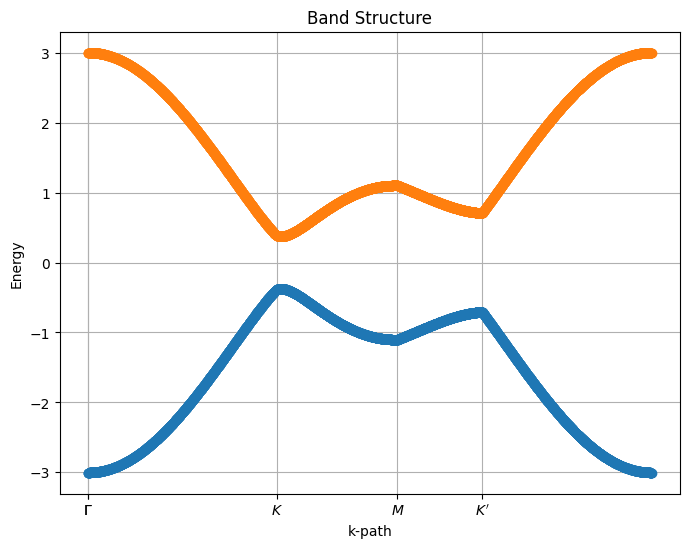

In [16]:
# High-symmetry points in reciprocal space
# Gamma = np.array([0, 0])  # Gamma point
# K = np.array([4 * np.pi / 3, 0])  # K point
# M = np.array([np.pi, np.pi / np.sqrt(3)])  # M point
# K_prime = np.array([-4 * np.pi / 3, 0])  # K' point

Gamma = np.array([0, 0])  # Gamma point
K = np.array([2.,1])  # K point
M = np.array([1,2])  # M point
K_prime = np.array([0,2])  # K' point

# Define the path as an array of high-symmetry points
path = [Gamma, K, M, K_prime, Gamma]

# Labels for the path
labels = [r'$\Gamma$', r'$K$', r'$M$', r"$K'$", r'$\Gamma$']

# Plot band structure along the path
plot_bandstructure(path, labels, H_calculator,params,1000)

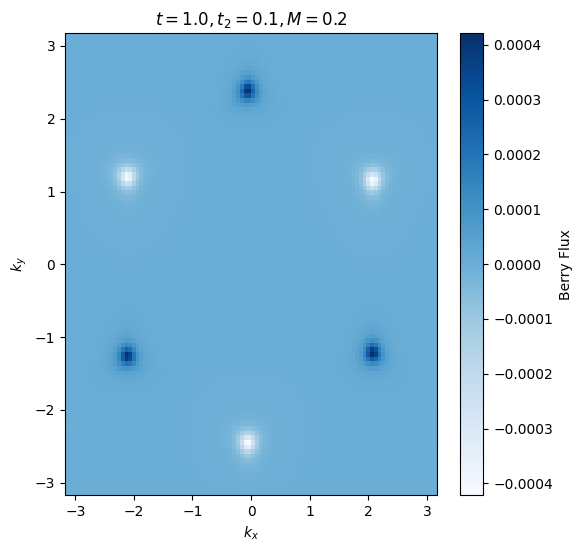

In [18]:
# Define the grid of k-points and Berry flux
N_grid = 100  # The number of points along each axis of the grid
kpoints = generate_kgrid(N_grid)
dkx = 2 * np.pi / N_grid
dky = 2 * np.pi / N_grid

berry_flux = compute_berry_curvature_wilson(kpoints, dkx, dky, 0, H_calculator, params)

# Reshape kx, ky, and berry_flux to fit a grid
kx = kpoints[:, 0].reshape(N_grid, N_grid)
ky = kpoints[:, 1].reshape(N_grid, N_grid)
berry_flux = berry_flux.reshape(N_grid, N_grid)

# Create the plot using pcolormesh for a smooth heatmap
plt.figure(figsize=(6, 6))
plt.pcolormesh(kx, ky, berry_flux, cmap='Blues', shading='auto')
plt.colorbar(label='Berry Flux')
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title(r'$t = 1.0, t_2 = 0.1, M = 0.2$')

plt.show()


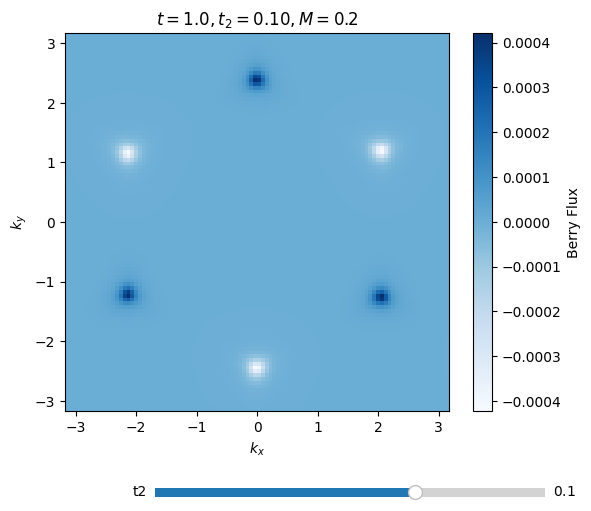

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Function to compute and plot the Berry curvature heatmap for a given t2
def plot_berry_curvature(ax, t2_value):
    ax.clear()
    
    # Define the parameters for the Haldane model
    params = {
        "t": 1.0,     # Nearest-neighbor hopping
        "t2": t2_value,   # Next-nearest-neighbor hopping (varied by slider)
        "M": 0.2,     # Staggered potential
        "phi": 0      # Complex phase
    }
    
    # Define the grid of k-points and Berry flux
    N_grid = 100  # The number of points along each axis of the grid
    kpoints = generate_kgrid(N_grid)
    dkx = 2 * np.pi / N_grid
    dky = 2 * np.pi / N_grid

    # Compute the Berry flux using the updated t2 value
    berry_flux = compute_berry_curvature_wilson(kpoints, dkx, dky, 0, H_calculator, params)

    # Reshape kx, ky, and berry_flux to fit a grid
    kx = kpoints[:, 0].reshape(N_grid, N_grid)
    ky = kpoints[:, 1].reshape(N_grid, N_grid)
    berry_flux = berry_flux.reshape(N_grid, N_grid)

    # Create the plot using pcolormesh for a smooth heatmap
    c = ax.pcolormesh(kx, ky, berry_flux, cmap='Blues', shading='auto')
    ax.set_xlabel(r'$k_x$')
    ax.set_ylabel(r'$k_y$')
    ax.set_title(r'$t = 1.0, t_2 = {:.2f}, M = 0.2$'.format(t2_value))
    return c

# Setup the figure and initial plot
fig, ax = plt.subplots(figsize=(6, 6))
plt.subplots_adjust(left=0.1, bottom=0.25)
initial_t2 = 0.1
c = plot_berry_curvature(ax, initial_t2)
cbar = fig.colorbar(c, ax=ax, label='Berry Flux')

# Create the slider
ax_t2 = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
t2_slider = Slider(ax_t2, 't2', -0.3, 0.3, valinit=initial_t2, valstep=0.01)

# Update function for the slider
def update(val):
    t2 = t2_slider.val
    c = plot_berry_curvature(ax, t2)
    cbar.update_normal(c)
    fig.canvas.draw_idle()

# Call update function when the slider value is changed
t2_slider.on_changed(update)

plt.show()


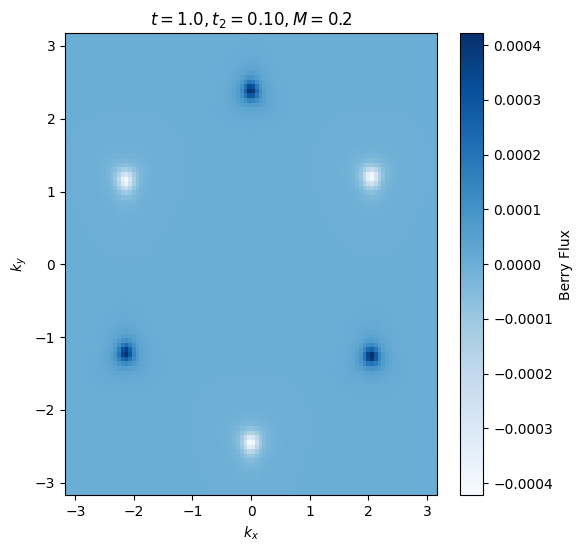

interactive(children=(FloatSlider(value=0.1, description='t2', max=0.3, min=-0.3, step=0.01), Output()), _dom_…

<function __main__.plot_berry_curvature(t2_value)>

In [19]:
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

# Function to compute and plot the Berry curvature heatmap for a given t2
def plot_berry_curvature(t2_value):
    # Define the parameters for the Haldane model
    params = {
        "t": 1.0,     # Nearest-neighbor hopping
        "t2": t2_value,   # Next-nearest-neighbor hopping (varied by slider)
        "M": 0.2,     # Staggered potential
        "phi": 0      # Complex phase
    }
    
    # Define the grid of k-points and Berry flux
    N_grid = 100  # The number of points along each axis of the grid
    kpoints = generate_kgrid(N_grid)
    dkx = 2 * np.pi / N_grid
    dky = 2 * np.pi / N_grid

    # Compute the Berry flux using the updated t2 value
    berry_flux = compute_berry_curvature_wilson(kpoints, dkx, dky, 0, H_calculator, params)

    # Reshape kx, ky, and berry_flux to fit a grid
    kx = kpoints[:, 0].reshape(N_grid, N_grid)
    ky = kpoints[:, 1].reshape(N_grid, N_grid)
    berry_flux = berry_flux.reshape(N_grid, N_grid)

    # Create the plot using pcolormesh for a smooth heatmap
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(kx, ky, berry_flux, cmap='Blues', shading='auto')
    plt.colorbar(label='Berry Flux')
    plt.xlabel(r'$k_x$')
    plt.ylabel(r'$k_y$')
    plt.title(r'$t = 1.0, t_2 = {:.2f}, M = 0.2$'.format(t2_value))
    plt.show()

# Create an interactive slider for t2
t2_slider = FloatSlider(min=-0.3, max=0.3, step=0.01, value=0.1, description="t2")

# Use interact to tie the slider to the plot_berry_curvature function
interact(plot_berry_curvature, t2_value=t2_slider)


In [26]:
# Compute the Chern number
chern_number = compute_chern_number(kpoints, dkx, dky, bnd_idx=0, H_calculator=H_calculator)
print(f"Computed Chern Number: {chern_number}")

Computed Chern Number: 0.002288750169918881


In [55]:
def compute_berry_phase(H_calculator, kpoints, band_idx):
    """
    Compute Berry phase for a given band along a path in k-space.
    
    H_calculator: Function that returns the Hamiltonian at a given k-point.
    kpoints: Array of k-points along the path.
    band_idx: The index of the band (0 for lower band, 1 for upper band).
    """
    berry_phase = 0.0
    _, psi = compute_eigenstuff(H_calculator, kpoints)  # Get eigenvectors

    # Accumulate the Berry phase by computing overlaps between neighboring k-points
    for i in range(len(kpoints) - 1):
        # Overlap between eigenvectors at neighboring k-points
        overlap = np.vdot(psi[i][:, band_idx], psi[i + 1][:, band_idx])
        berry_phase += np.angle(overlap)  # Add the phase of the overlap
    
    return berry_phase

def plot_berry_phase(kx_values, H_calculator, N=100):
    """
    Plot Berry phase along k_x for both bands (lower and upper).
    
    kx_values: Array of k_x values to compute the Berry phase along.
    H_calculator: Function that returns the Hamiltonian at a given k-point.
    """
    lower_band_phases = []
    upper_band_phases = []
    both_band_phases = []

    # Generate k-points along the kx path
    for kx in kx_values:
        ky_points = np.linspace(-np.pi, np.pi, N)
        kpoints = np.array([[kx, ky] for ky in ky_points])
        
        # Compute Berry phases for lower (0) and upper (1) bands
        lower_phase = compute_berry_phase(H_calculator, kpoints, 0)
        upper_phase = compute_berry_phase(H_calculator, kpoints, 1)
        
        lower_band_phases.append(lower_phase)
        upper_band_phases.append(upper_phase)
        both_band_phases.append(lower_phase + upper_phase)

    # Plot the Berry phases
    plt.figure(figsize=(8, 6))
    plt.plot(kx_values, lower_band_phases, 'ro-', label='Lower band')
    plt.plot(kx_values, upper_band_phases, 'go-', label='Upper band')
    plt.plot(kx_values, both_band_phases, 'bo-', label='Both bands')
    
    plt.axhline(0, color='black', linestyle='--')
    plt.axhline(np.pi, color='gray', linestyle='--')
    plt.axhline(-np.pi, color='gray', linestyle='--')
    
    plt.xlabel(r'$k_x$')
    plt.ylabel(r'Berry phase')
    plt.legend()
    plt.grid(True)
    plt.title('Berry Phase along $k_x$')
    plt.show()


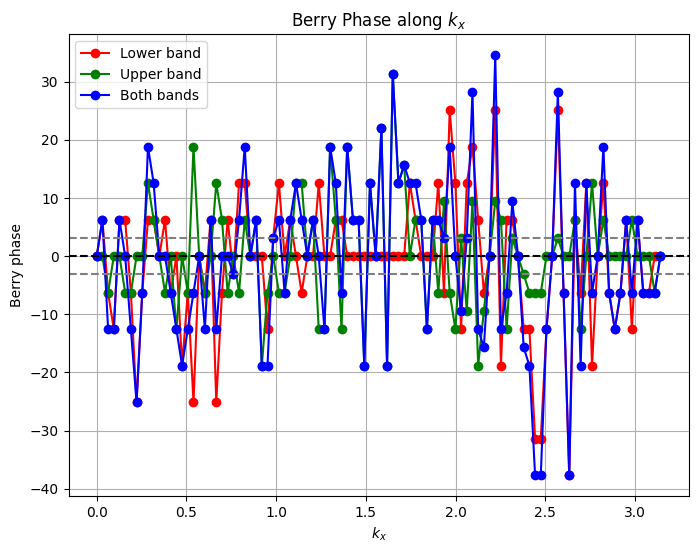

In [56]:
# Define a range of kx values to compute Berry phase
kx_values = np.linspace(0, np.pi, 100)

# Plot Berry phase along kx
plot_berry_phase(kx_values, H_calculator, N=100)


In [ ]:
def generate_coarse_grid(N):
    """Generate a coarse grid of k-points for the entire BZ."""
    kx = np.linspace(-np.pi, np.pi, N)
    ky = np.linspace(-np.pi, np.pi, N)
    kpoints = np.array([[kx[i], ky[j]] for i in range(N) for j in range(N)])
    return kpoints

def generate_fine_grid(center, delta, N_fine):
    """Generate a fine grid of k-points around a specified center."""
    kx = np.linspace(center[0] - delta, center[0] + delta, N_fine)
    ky = np.linspace(center[1] - delta, center[1] + delta, N_fine)
    fine_grid = np.array([[kx[i], ky[j]] for i in range(N_fine) for j in range(N_fine)])
    return fine_grid

def combine_grids(coarse_grid, fine_grids):
    """Combine coarse and fine grids, ensuring no duplicates."""
    all_kpoints = np.vstack((coarse_grid, *fine_grids))
    # Remove duplicate k-points (if any) by rounding to avoid numerical issues
    unique_kpoints = np.unique(np.round(all_kpoints, decimals=8), axis=0)
    return unique_kpoints
